<a href="https://colab.research.google.com/github/fares-mldev/uns-pdi2021/blob/main/tp5/PDI_TP5_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctico TP5 (Transformada de Fourier 2D)

Armar un aplicativo como el mostrado en este apunte, que permita la generación de TFs
directas e inversas de imágenes. Probarlo con diferentes figuras geométricas y tratar de reproducir algunos de los
ejemplos vistos aquí. Generar otros ejemplos (elipses, rombos, dos o más objetos, etc.). Guardar el espectro de amplitud de una imagen en un bitmap, luego editarlo con un
editor gráfico, y finalmente aplicar la transformada inversa (preservando la fase) para ver
los efectos. 



In [1]:
#@title Imports

# Import numpy
import numpy as np

# Import imageio
import imageio as iio

# Import matplotlib
import matplotlib.pyplot as plt

# Import widgets
import ipywidgets as widgets
from IPython.display import display


In [2]:
#@title Image utils

# Images URL list 
url_dict = {}
url_dict["square"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/square.jpg"
url_dict["circle"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/circle.jpg"
url_dict["triangle"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/triangle.jpg"
url_dict["elipse"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/elipse.jpg"
url_dict["rhombus"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/rhombus.jpg"
url_dict["h_lines"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/h_lines.jpg"
url_dict["v_lines"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/v_lines.jpg"
url_dict["d_lines"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/d_lines.jpg"
url_dict["pattern1"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/pattern1.jpg"
url_dict["pattern2"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/pattern2.jpg"

def get_image(image: str) -> np.array:
    '''
    Downloads specified image from the web and returns it as a numpy array
    '''
    # Read image from file
    img = iio.imread(url_dict[image])

    # Return image
    return np.asarray(img)

# RGB to YIQ space transformation matrix
rgb_to_yiq = [[0.299, 0.587, 0.114],
              [0.595716, -0.274453, -0.321263],
              [0.211456, -0.522591, 0.311135]]

# YIQ to RGB space transformation matrix
yiq_to_rgb = [[1, 0.9663, 0.6210],
              [1, -0.2721, -0.6474],
              [1, -1.1070, 1.7046]]

def plot_img(img: np.array, ax = None):
  '''
  Plots image using matplotlib 
  '''

  # If no axis sprecified get handle
  if ax is None:
    ax = plt.gca()

  # Show image
  ax.imshow(img)

def describe_img(img: np.array):
  '''
  Prints image properties
  '''
  print("Image shape (height,width,channels):", img.shape)
  print("Element type:", img.dtype)
  print("Total number of pixels:",img.size)
  print("Pixels per channel:", int(img.size/img.shape[2]))
  print("min-max value of channel 0:",img[:,:,0].min(),img[:,:,0].max())
  print("min-max value of channel 1:",img[:,:,1].min(),img[:,:,1].max())
  print("min-max value of channel 2:",img[:,:,2].min(),img[:,:,2].max())
  
def convert_rgb2yiq(img_rgb: np.array) -> np.array:
  '''
  Converts an RGB image to YIQ space
  '''
  
  # Normalize image
  img_rgb_n = img_rgb.astype(np.float64) / 255.0  
  
  # Apply transformation
  img_yiq = np.dot(img_rgb_n,rgb_to_yiq)
  
  # Clip to limits

  # Return YIQ image
  return img_yiq

def convert_yiq2rgb(img_yiq: np.array) -> np.array:
  '''
  Converts an YIQ image to RGB space
  '''

  # Apply transformation
  img_rgb_n= np.dot(img_yiq,yiq_to_rgb)
  
  # Clip image 
  img_rgb = img_rgb_n.clip(0,1) * 255.0
  
  # Return RGB image
  return img_rgb.astype(np.uint8) 

def get_y(im):
  '''
  Gets the luminance (Y) channel of an image
  '''
  return convert_rgb2yiq(im)[:,:,0]

def get_fft(im):
  '''
  Gets the magnitude and phase channels on an image
  '''
  fc = np.fft.fftshift(np.fft.fft2(im))

  mag = np.abs(fc)
  phase = np.angle(fc)

  return mag,phase

def get_ifft(fft_img):
    
  # reverse the 2D fourier transform
  img = np.fft.ifft2(np.fft.ifftshift(fft_img))
  img = np.abs(img)

  return img


def polar_to_complex(mag, phase):
  '''
  Recovers complex from magnitude and phase  
  '''
  return np.multiply(mag,np.exp(1j*phase))

def plot_fft(im, desc= '', type = 'log'):
  '''
  Plots an image, together with its fft magnitude and phase
  '''
  fig, axes = plt.subplots(1,3)
  fig.set_size_inches(21,7)
  mag, phase = get_fft(im)

  axes[0].imshow(im, cmap = 'gray')
  axes[0].set_title(desc)
  if type == 'log':
    axes[1].imshow(np.log(mag), cmap = 'gray')
  if type == 'sqrt':
    axes[1].imshow(np.power(mag,0.2), cmap = 'gray')
  
  axes[1].set_title('fft magnitude')
  axes[2].imshow(phase, cmap = 'gray')
  axes[2].set_title('fft phase')
  
def save_img(fn: str, im: np.array):
  '''
  Saves a image to disk
  '''
  # Clip and scale image 
  im = im.clip(0,1) * 255.0
  im = im.astype(np.uint8) 

  # Write to file
  iio.imwrite(fn,im)

def save_fig(fn):
  # Write results to file
  fig = plt.gcf()
  fig.savefig(fn)

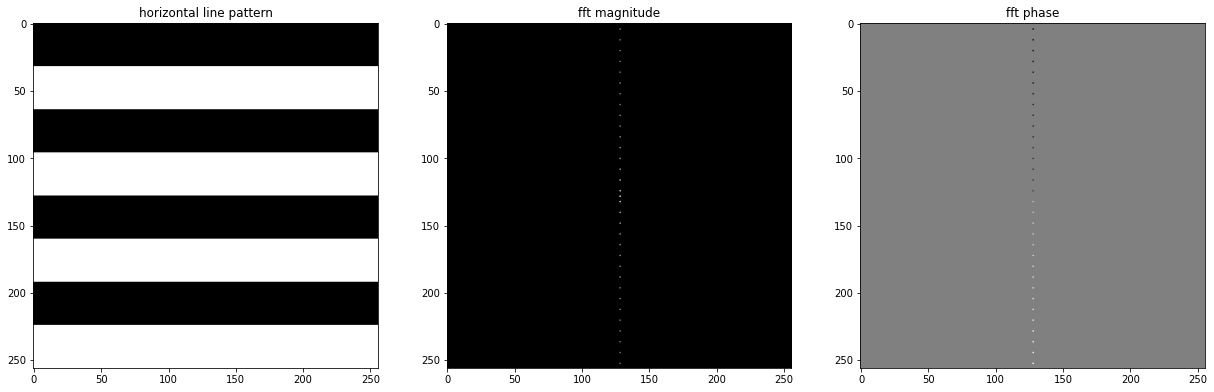

In [3]:
#@title Patrón lineas horizontales { run: "auto" }
n = 8 #@param {type:"slider", min:2, max:16, step:2}

def create_hlines(h=256,w=256,n=8):
  '''
  Creates a n horizontal line pattern
  '''
  # init image
  im = np.zeros((w,h))
  
  # line size
  size = h / n
  
  # loop over rows
  for row in range(h):
    im[row,:] = int((row/size) % 2) 

  return im

im = create_hlines(n=n)
plot_fft(im, 'horizontal line pattern', type = 'sqrt')

# Save image and figure
fn = f'hlines_{n:d}'
save_img(fn+'.tif',im)
fig = plt.gcf()
fig.savefig(fn+'_fft')


Se observa que el patrón genera componentes discretos en frecuencia sobre una línea vertical. A menor ancho de líneas, mayor separación de los puntos.

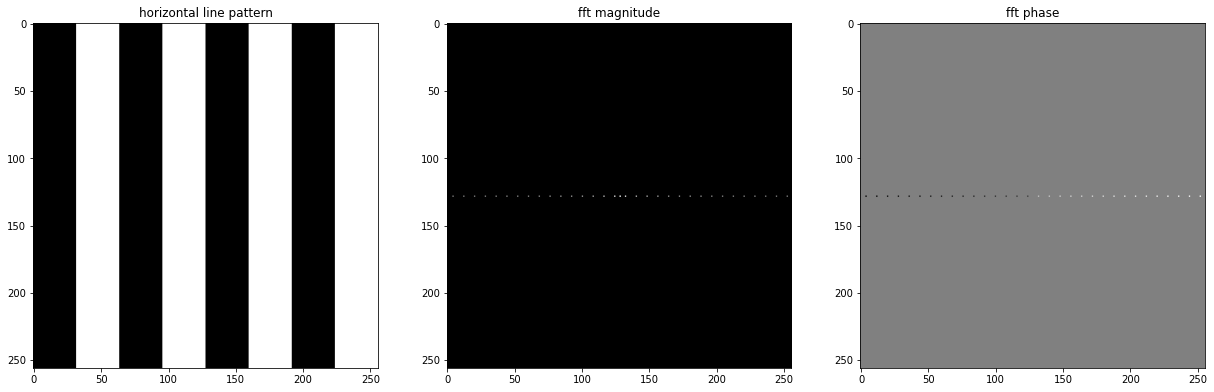

In [4]:
#@title Patrón lineas verticales { run: "auto" }
m = 8 #@param {type:"slider", min:2, max:16, step:2}

def create_vlines(h=256,w=256,m=8):
  '''
  Creates a n horizontal line pattern
  '''
  # init image
  im = np.zeros((w,h))
  
  # line size
  size = w / m
  
  # loop over columns
  for column in range(w):
    im[:,column] = int((column/size) % 2) 

  return im

im = create_vlines(m=m)
plot_fft(im, 'horizontal line pattern', type = 'sqrt')

# Save image and figure
fn = f'vlines_{m:d}'
save_img(fn+'.tif',im)
fig = plt.gcf()
fig.savefig(fn+'_fft')

Se observa que el patrón genera componentes discretos en frecuencia sobre una línea horizontal. A menor ancho de líneas, mayor separación de los puntos.

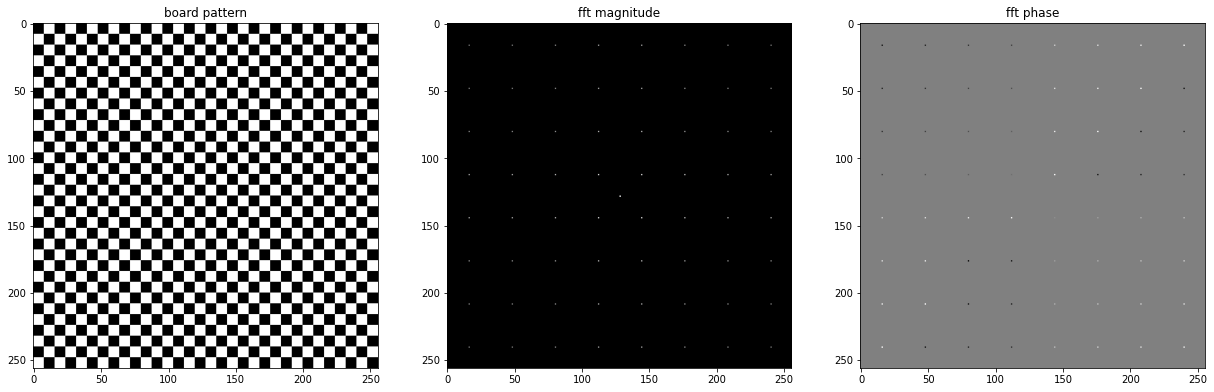

In [5]:
#@title Patrón tablero { run: "auto" }
size_h = 8 #@param {type:"slider", min:2, max:16, step:2}
size_w = 8 #@param {type:"slider", min:2, max:16, step:2}

def create_board(h=256,w=256,size_h=8,size_w=8):
  '''
  Creates a n horizontal line pattern
  '''
  # init image
  im = np.zeros((w,h))

  # Loop over rows and cols  
  for row in range(h):
    for col in range(w):
      im[row,col] = ( row // size_h + col // size_w ) % 2

  return im

im = create_board(size_h=size_h,size_w=size_w)
plot_fft(im, 'board pattern', type='sqrt')

# Save image and figure
fn = f'board_{size_h:d}x{size_w:d}'
save_img(fn+'.tif',im)
fig = plt.gcf()
fig.savefig(fn+'_fft')

Se observa que el patrón genera componentes en frecuencia discretos sobre una grilla. A menor tamaño de las celdas, mayor separación de los puntos.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in log


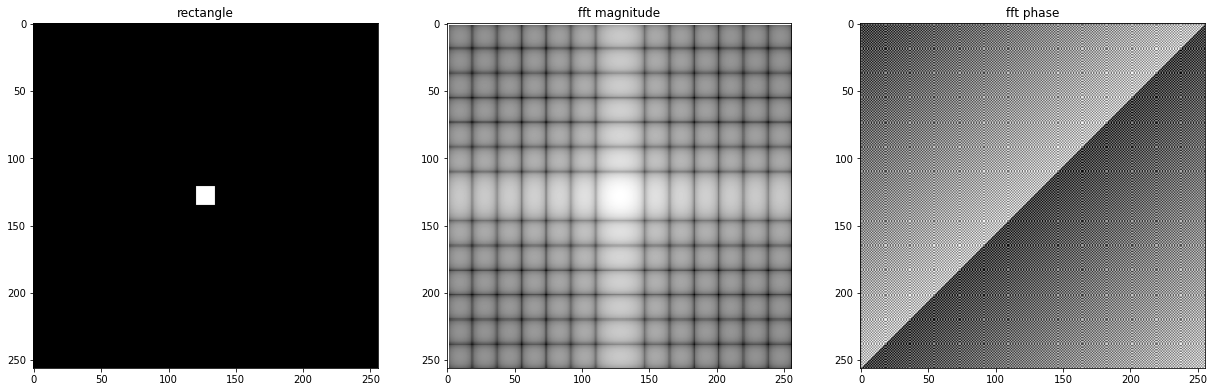

In [6]:
#@title Rectangulo { run: "auto" }

size_h = 15 #@param {type:"slider", min:5, max:100, step:5}
size_w = 15 #@param {type:"slider", min:5, max:100, step:5}

def create_rect(h=256,w=256,size_h=8,size_w=8):
  '''
  Creates a centred rectangle
  '''
  # init image
  im = np.zeros((w,h))
  
  centre_h = int(h / 2)
  centre_w = int(w / 2)

  im[(centre_h-size_h//2):(centre_h+size_h//2),(centre_w-size_w//2):(centre_w+size_w//2)] = 1

  return im

im = create_rect(size_h=size_h,size_w=size_w)
plot_fft(im, 'rectangle')

# Save image and figure
fn = f'rect_{size_h:d}x{size_w:d}'
save_img(fn+'.tif',im)
fig = plt.gcf()
fig.savefig(fn+'_fft')

Se observa un patrón contínuo en frecuencia agrupados en forma grilla. A menor tamaño del cuadrado/rectánculo, mayor tamaño (dispersión) de las celdas en frecuencia.

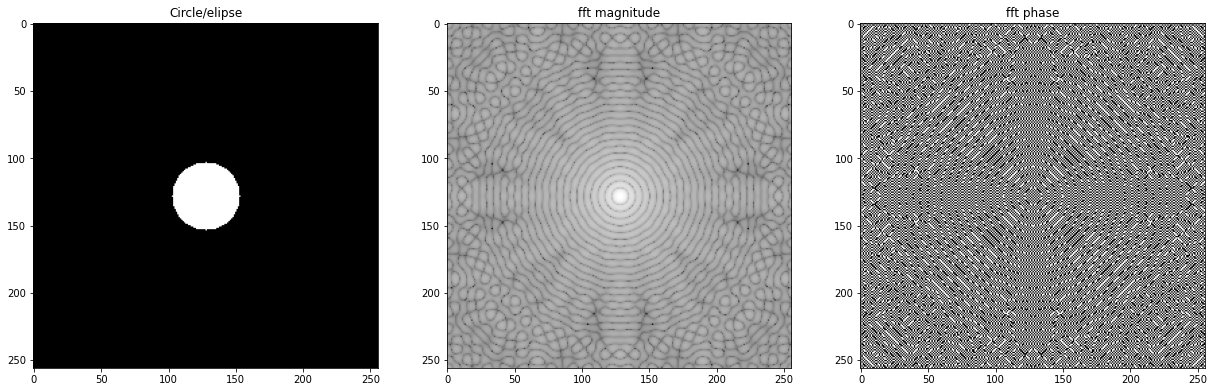

In [7]:
#@title Circulo/Elipse { run: "auto" }

radio = 25 #@param {type:"slider", min:5, max:50, step:5}
ratio = 1 #@param {type:"slider", min:0.5, max:2, step:0.1}

def create_elipse(h=256,w=256,a=8,b=8):
  '''
  Creates a centred elipse
  '''
  # init image
  im = np.zeros((w,h))
  
  centre_h = int(h / 2)
  centre_w = int(w / 2)

  for row in range(h):
    for col in range(w):
      im[row,col] = int ((np.square(row-centre_h) / np.square(a) + np.square(col-centre_w) / np.square(b)) <= 1)

  return im

im = create_elipse(a=radio/ratio,b=radio*ratio)

plot_fft(im, 'Circle/elipse')

# Save image and figure
str_ratio = str(ratio).replace('.','_')
fn = f'circ_{radio:d}x{str_ratio:s}'
save_img(fn+'.tif',im)
fig = plt.gcf()
fig.savefig(fn+'_fft')

Se observa un patrón contínuo en frecuencia en forma grilla de anillos. A menor tamaño del círculo/elipse sobre una dimensión, mayor tamaño (dispersión) de los anillos en frecuencia. Se observan patrones de aliasing, sobre todo en frecuencias altas, o dimensiones pequeñas del circulo/elipse de la imagen.

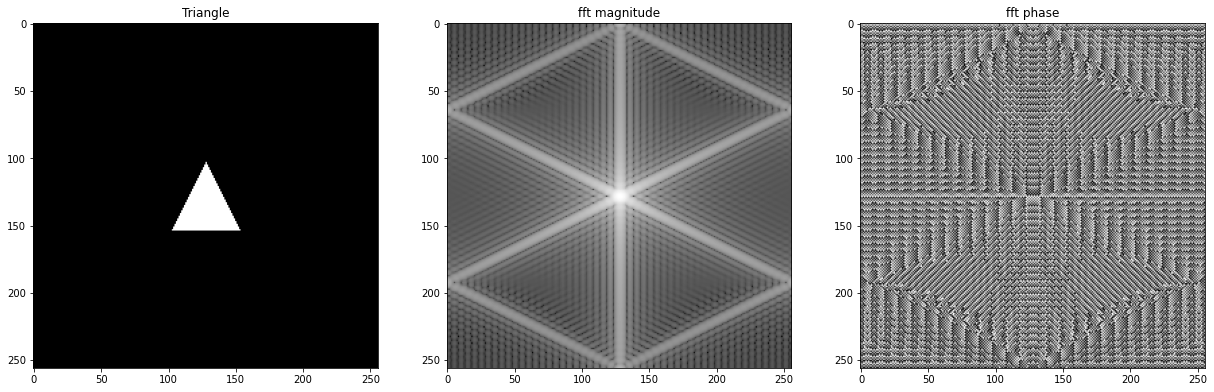

In [8]:
#@title Triangulo { run: "auto" }

base = 50 #@param {type:"slider", min:5, max:100, step:5}
ratio = 1 #@param {type:"slider", min:0.5, max:2, step:0.1}

from PIL import Image, ImageDraw

def create_triangle(h=256,w=256,base=50,height=50):
  '''
  Creates a centred triangle
  '''
  # init image
  im = Image.new('L', (w, h), 0)
  
  centre_h = h // 2
  centre_w = w // 2

  polygon = [(centre_w,centre_h-height//2),(centre_w-base//2,centre_h+height//2),(centre_w+base//2,centre_h+height//2)]

  ImageDraw.Draw(im).polygon(polygon, outline=1, fill=1)

  #im = im.resize((w, h), resample=Image.ANTIALIAS)

  return np.array(im)

im = create_triangle(base=base,height=ratio*base)

plot_fft(im, 'Triangle')

# Save image and figure
str_ratio = str(ratio).replace('.','_')
fn = f'trian_{base:d}x{str_ratio:s}'
save_img(fn+'.tif',im)
fig = plt.gcf()
fig.savefig(fn+'_fft')



Se observa un patrón en tres direcciones (perpendicular a cada uno de los lados).  

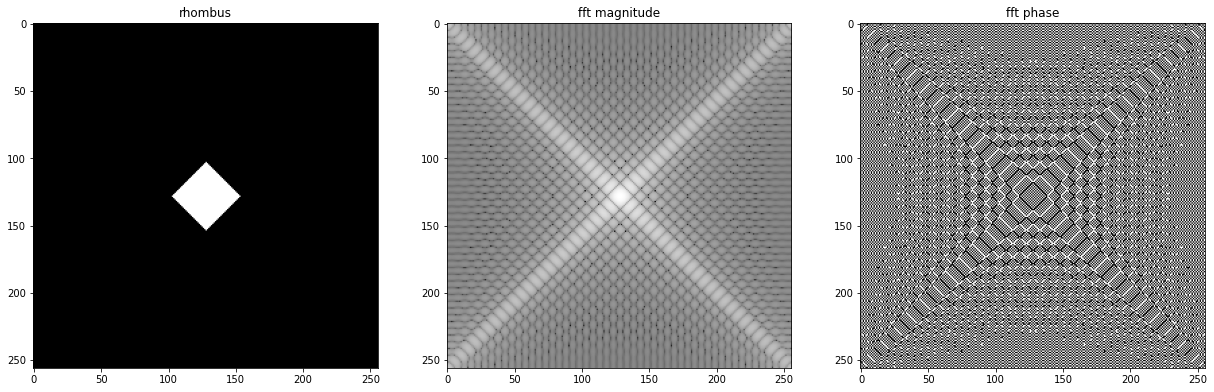

In [9]:
#@title Rombo { run: "auto" }

ancho = 50 #@param {type:"slider", min:5, max:100, step:5}
ratio = 1 #@param {type:"slider", min:0.5, max:2, step:0.1}

from PIL import Image, ImageDraw

def create_rhombus(h=256,w=256,width=50,height=50):
  '''
  Creates a centred triangle
  '''
  # init image
  im = Image.new('L', (w, h), 0)
  
  centre_h = h // 2
  centre_w = w // 2

  polygon = [(centre_w,centre_h-height//2),
             (centre_w+width//2,centre_h),
             (centre_w,centre_h+height//2),
             (centre_w-width//2,centre_h)]

  ImageDraw.Draw(im).polygon(polygon, outline=1, fill=1)

  return np.array(im)

im = create_rhombus(width=ancho,height=ancho*ratio)

plot_fft(im, 'rhombus')

# Save image and figure
str_ratio = str(ratio).replace('.','_')
fn = f'rhomb_{ancho:d}x{str_ratio:s}'
save_img(fn+'.tif',im)
fig = plt.gcf()
fig.savefig(fn+'_fft')



Se observa un patrón similar al cuadrado, pero girado en 45°. Al alterar la forma, se observa que las componentes en frecuencia se distribuyen a lo largo de líneas perpendiculares a los lados de la figura (similar al rectángulo).

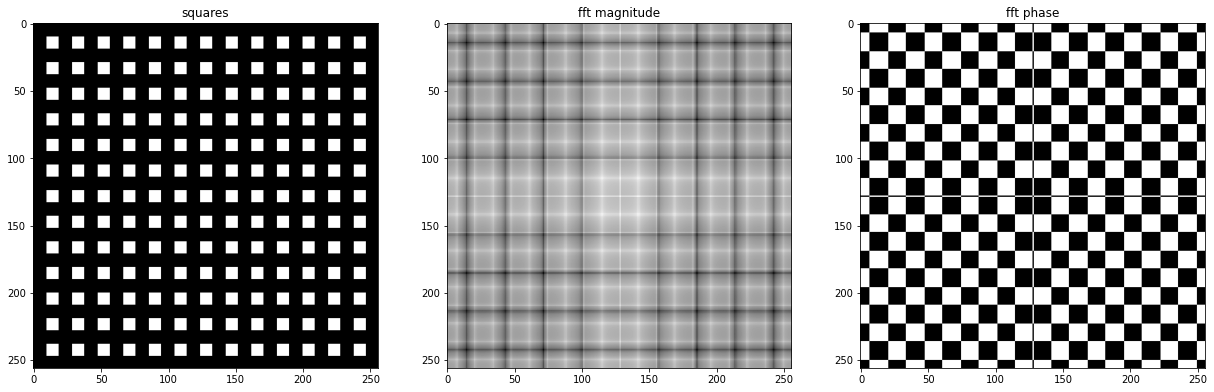

In [10]:

#@title Repetición { run: "auto" }

n = 13 #@param {type:"slider", min:1, max:31, step:1}

im = np.multiply(create_hlines(h=256,w=256,n=n*2+1) , create_vlines(h=256,w=256,m=n*2+1)) 


plot_fft(im, 'squares')

# Save image and figure
str_ratio = str(ratio).replace('.','_')
fn = f'rep_{n:d}x{n:d}'
save_img(fn+'.tif',im)
fig = plt.gcf()
fig.savefig(fn+'_fft')


Se observa un patrón de repetición en el espectro

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in log


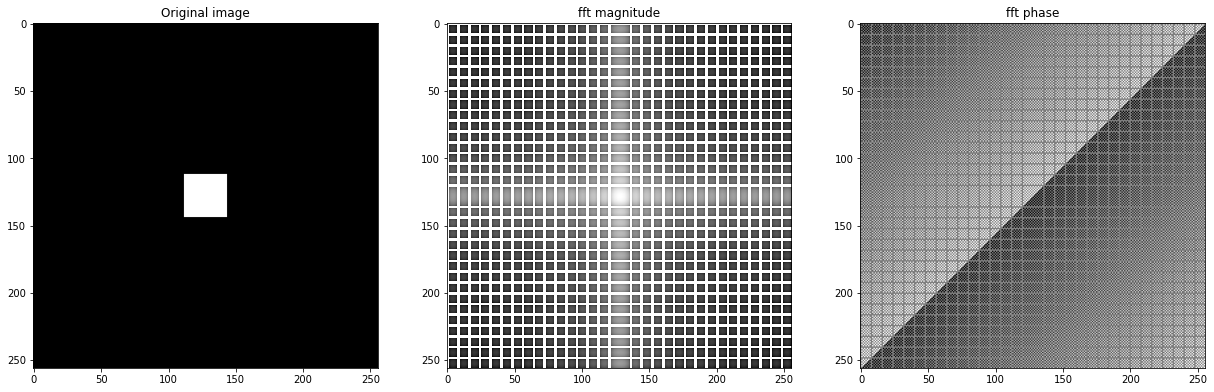

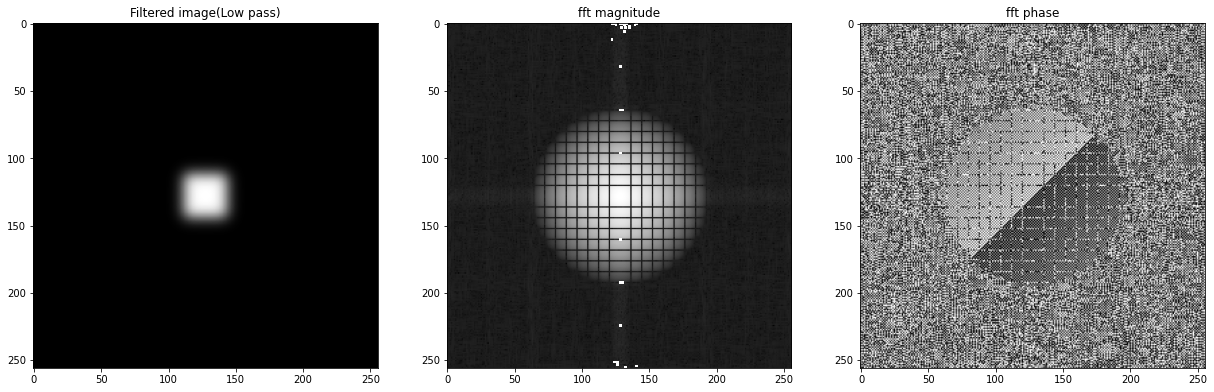

In [11]:

#@title Filtrado pasabajos (Low pass) { run: "auto" }
#@markdown Se multiplica la magnitud del espectro por una campana gaussiana 2D. De esta forma se atenúan las altas frecuencias, observándose como una pérdida de definición en los bordes de la imagen
sigma = 8 #@param {type:"slider", min:1, max:15, step:1}

def create_gaussian(h, w,sigma):
  X = np.arange(-h//2, h//2)
  Y = np.arange(-w//2, w//2)
  X, Y = np.meshgrid(X, Y)
  R = np.sqrt(X**2 + Y**2)
  Z = ((1. / np.sqrt(2 * np.pi)) * np.exp(-.5*(R/sigma)**2))
  return Z

# Create image
im_orig = create_rect(size_h=32,size_w=32)

# Create filter image
im_filt = create_gaussian(256,256,sigma)
im_filt = (im_filt-np.min(im_filt))/(np.max(im_filt)-np.min(im_filt))

# Apply filter image
fc = np.fft.fftshift(np.fft.fft2(im_orig)) * (im_filt)

# Anti-transform
im=get_ifft(fc)

# Plot results
fn = f'filter_lp_{sigma:d}'

plot_fft(im_orig, 'Original image')
fig = plt.gcf()
fig.savefig(fn+'_orig')

plot_fft(im, 'Filtered image(Low pass)')
fig = plt.gcf()
fig.savefig(fn+'_fft')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in log


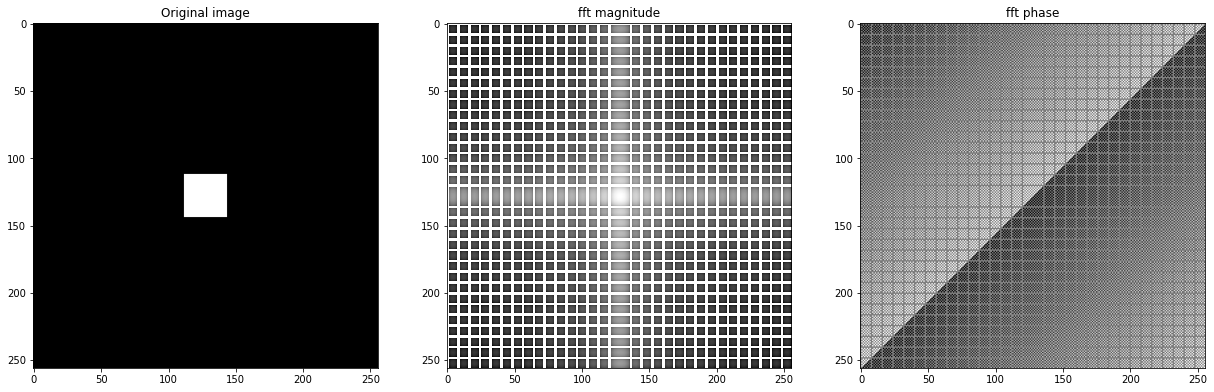

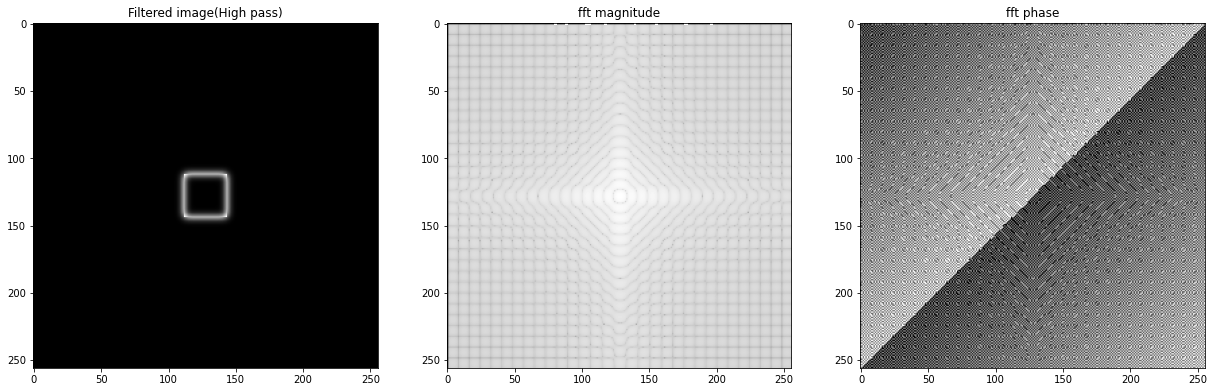

In [12]:
#@title Filtrado altos (High pass) { run: "auto" }
#@markdown Se multiplica la magnitud del espectro por una campana gaussiana 2D invertida (1-z). 
#@markdown De esta forma se atenúan las bajas frecuencias, resaltándose los bordes de la imagen

sigma = 15 #@param {type:"slider", min:1, max:15, step:1}

def create_gaussian(h, w,sigma):
  X = np.arange(-h//2, h//2)
  Y = np.arange(-w//2, w//2)
  X, Y = np.meshgrid(X, Y)
  R = np.sqrt(X**2 + Y**2)
  Z = ((1. / np.sqrt(2 * np.pi)) * np.exp(-.5*(R/sigma)**2))
  return Z

# Create image
im_orig = create_rect(size_h=32,size_w=32)

# Create filter image
im_filt = create_gaussian(256,256,sigma)
im_filt = (im_filt-np.min(im_filt))/(np.max(im_filt)-np.min(im_filt))

# Apply filter image
fc = np.fft.fftshift(np.fft.fft2(im_orig)) * (1- im_filt)

# Anti-transform
im=get_ifft(fc)

# Plot results
fn = f'filter_hp_{sigma:d}'

plot_fft(im_orig, 'Original image')
fig = plt.gcf()
fig.savefig(fn+'_orig')

plot_fft(im, 'Filtered image(High pass)')
fig = plt.gcf()
fig.savefig(fn+'_fft')